In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time
from langchain.callbacks import get_openai_callback
import datetime
from tqdm import tqdm
import itertools
import joblib
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
import random
import seaborn as sns

In [2]:
API_KEY_PATH = "../key"

with open(API_KEY_PATH, "r") as fp:
    API_KEY = fp.read().strip()

In [3]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

plan_llm = ChatOpenAI(openai_api_key=API_KEY, temperature=0.7,
                      model_name="gpt-4-1106-preview")
memory = ConversationBufferMemory(return_messages=True)
system_prompt = SystemMessagePromptTemplate.from_template("You are an AI assistant that will come up with test prompts that can be used to generate long response for "
                                                          "benchmarking the token generation rate of large language models.")
user_prompt = HumanMessagePromptTemplate.from_template("Give me a new prompt.")
chat_prompt = ChatPromptTemplate.from_messages([system_prompt, MessagesPlaceholder(variable_name="history"), user_prompt])
augment_chain = RunnablePassthrough.assign(
        history=RunnableLambda(memory.load_memory_variables) | itemgetter("history")
    ) | chat_prompt | plan_llm

In [4]:
test_prompts = []
parallel = joblib.Parallel(n_jobs=8, return_as="generator")
with tqdm(total=60) as progress:
    for i in parallel(joblib.delayed(augment_chain.invoke)({}) for _ in range(60)):
        test_prompts.append(i.content)
        progress.update(1)
print(test_prompts[0])

100%|██████████| 60/60 [00:22<00:00,  2.67it/s]

Prompt: "Write a comprehensive guide explaining the steps involved in planning and executing an international scientific expedition to study the effects of climate change on remote Arctic ecosystems. Include details on obtaining funding, necessary equipment, team composition, logistics, data collection methods, and strategies for overcoming potential challenges."


In [5]:
%%time
def benchmark_model(model, prompt):
    llm = ChatOpenAI(openai_api_key=API_KEY, temperature=0.7,
                      model_name=model, max_tokens=512, max_retries=0, request_timeout=40)
    bench_prompt = PromptTemplate.from_template(prompt)
    chain = bench_prompt | llm
    while True:
        try:
            with get_openai_callback() as cb:
                time_start = datetime.datetime.now()
                _ = chain.invoke({})
                time_end = datetime.datetime.now()
                return (time_end - time_start) / cb.completion_tokens
        except Exception as e:
            print(e, flush=True)
            time.sleep(20 + random.randint(1, 20))
            pass


test_models = ["gpt-4-1106-preview", "gpt-4-vision-preview", "gpt-4-0613", "gpt-3.5-turbo-1106", "gpt-3.5-turbo-0613", "gpt-3.5-turbo-16k-0613"]
models = []
deltas = []

with tqdm(total=len(test_models) * len(test_prompts)) as progress:
    jobs = [(m, p) for m, p in itertools.product(test_models, test_prompts)]
    for i, result in enumerate(parallel(joblib.delayed(benchmark_model)(*args) for args in jobs)):
        deltas.append(result)
        models.append(jobs[i][0])
        progress.update(1)


 17%|█▋        | 60/360 [01:43<06:42,  1.34s/it] 

Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=40.0)
Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=40.0)
Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=40.0)
Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=40.0)
Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=40.0)
Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=40.0)
Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=40.0)
Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=40.0)
Rate limit reached for gpt-4-vision-preview in organization org-muiqeEVHBsuYbgt2p54Es1zo on requests per day (RPD): Limit 100, U

 17%|█▋        | 60/360 [03:34<17:52,  3.58s/it]


KeyboardInterrupt: 

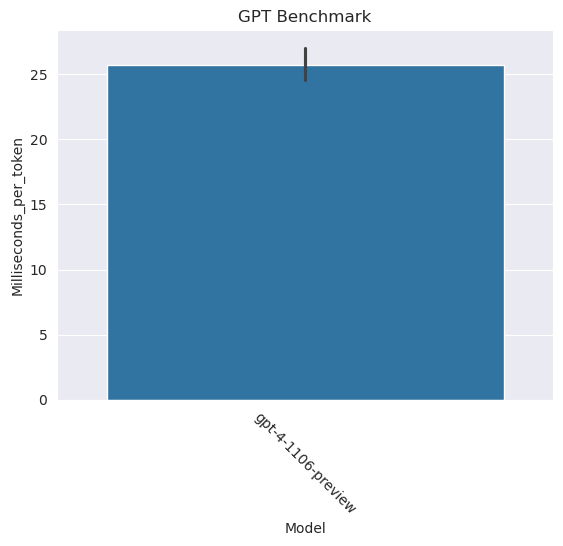

In [6]:
bench_df = pd.DataFrame({
    "Model": models,
    "Milliseconds_per_token": deltas
})
bench_df["Milliseconds_per_token"] = bench_df["Milliseconds_per_token"].apply(lambda t: t.total_seconds() * 1000)
sns.barplot(data=bench_df, x="Model", y="Milliseconds_per_token", hue="Model")
plt.title("GPT Benchmark")
plt.xticks(rotation=-45)
plt.show()